Fig9b, left, I-V curve, simple model with soma of different sizes

In [1]:
from neuron import h
import numpy as np
import os.path
import sys
sys.path.append('../../libs/')

In [2]:
# load model
# works only on linux
model = '../../data/morphology/soma_axon.hoc'
dllpath = '../../data/morphology/x86_64/.libs/libnrnmech.so'
h.nrn_load_dll(dllpath)
h.load_file(model)
h.init_cell()

0.0

In [3]:
# parameters
# I-V related
volt_range = [-65, -50]
no_pts = 15
ais = 10 # at which segment is ais (all the k and na channels are gathered)
axon_nseg = 10

# simulation
h.tstart = 0.
h.tstop = 20.
h.dt = 0.001
rm = 30000.
st_dur1 = 2.
st_dur2 = 3.
v_init = -70

# morphology 
h.axon.L = 50.
h.axon.diam =1.
h.soma.nseg = 6
h.soma.g_pas = 1./rm
h.soma.cm = 0.75

h.axon.L = 50.
h.axon.diam =1.
h.axon.nseg = axon_nseg
h.axon.g_pas = 1./rm
h.axon.cm = 0.75 * 0.75

# general
h.rm = rm
h.v_init = v_init
h.ra = 150 
h.c_m = 0.75
h.xn = 1 

# potassium
h.Ek = -80. # mV # Fig2: = 80; Fig4b:
h.gk = 1600.
h.gkm = 0.3
h.soma.gbar_kv = 1600/5.
h.axon.gbar_kv = 1600.

# sodium
h.Ena = 60.
h.gna = 8000.
h.gkm_soma = 0.3 
h.soma.gbar_na = 0 # 0.1*8000
            
# calcium (set no calcium in the model)
h.gca = 0.
h.gkca = 0.
h.gca_soma = 0.
h.gkca_soma = 0.

In [4]:
# move all the axonal K and Na channels into selected segment of the axon

# calculate axonal area
old_g_na = h.axon.gbar_na
old_g_kv = h.axon.gbar_kv
orig_axon_area = np.sum([seg.area() for 
                seg in h.axon.allseg()])
single_axon_area = orig_axon_area/h.axon.nseg

# set new K and Na
h.axon.gbar_na = 0
h.axon.gbar_kv = 0
h.axon(1.-(1./ais)).gbar_na = old_g_na*h.axon.nseg
h.axon(1.-(1./ais)).gbar_kv = old_g_kv*h.axon.nseg

In [5]:
# calculate current using p/n protocol

from apkink import protocols as pp
i_soma_pn = pp.pn_protocol(v_memb=v_init)

In [6]:
# calculate I-V for different holding volt

volt_space = np.linspace(volt_range[0], volt_range[1], no_pts)
i_space = np.zeros([no_pts])
m_axon_space = np.zeros([no_pts])

for idx,volt in enumerate(volt_space): 
    # create stimulation
    i_val, m_axon_val = pp.i_v_protocol(volt,v_memb=v_init,st_dur1=st_dur1,st_dur2=st_dur2)
    
    p_v_value = i_soma_pn*((volt-(v_init))/5.) 
    i_soma = i_val - p_v_value
    peak = min(i_soma[(st_dur1+st_dur2+0.2)/h.dt:(st_dur1+st_dur2+3.0)/h.dt])
    
    i_space[idx] = peak
    m_axon_space[idx] = np.max(m_axon_val)

/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


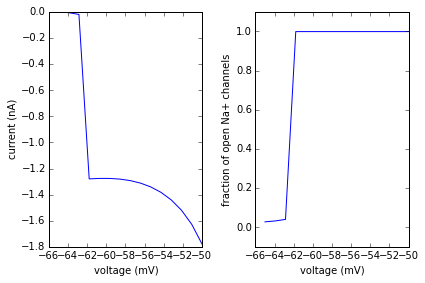

In [7]:
# plot the figure
import matplotlib.pylab as plt
%matplotlib inline
plt.subplot(1,2,1)

plt.plot(volt_space, i_space)
plt.ylabel('current (nA)')
plt.xlabel('voltage (mV)')
plt.subplot(1,2,2)
plt.plot(volt_space, m_axon_space)
plt.ylim([-.1,1.1])
plt.ylabel('fraction of open Na+ channels')
plt.xlabel('voltage (mV)')
plt.tight_layout()